4: LES ARBRES DE DECISION: 
Nous allons tester maintenant les arbres de décisions. Dans ces arbres chaque noeud divise les observations en 2 branches en fonction d'une condition (par exemple alcohol<=12) et chaque feuille de l'arbre correspondra à une qualité égale à la moyenne de la qualité des observations présentes dans la feuille.
Une nouvelle observation x n'aura qu'à suivre le chemin de l'arbre en fonction des conditions des noeuds pour atterir dans une feuille. La prédiction sera alors la qualité de la feuille.

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


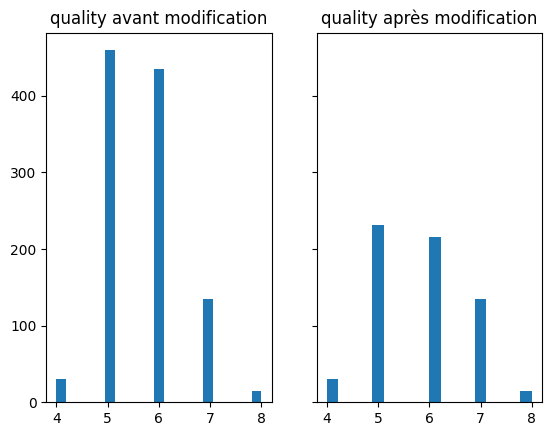

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

 # normalize the original features
X_train, X_mu, X_sigma = zscore_normalize_features(X_train)
X_cv, X_mu, X_sigma = zscore_normalize_features(X_cv)
X_test, X_mu, X_sigma = zscore_normalize_features(X_test)

On va commencer par mettre en place un arbre de décision:

In [3]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    
print(entropy(0.5))

1.0


In [11]:
def split_indices(X, index_feature):

    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

def split_indices_continue(X,t, index_feature):

    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] <= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [12]:
left,right=split_indices_continue(X_train,0.5, 0)
print(len(left),len(right))

[[-1.55797476 -1.85794854  0.67726385 ... -2.95477498 -0.48911183
  -0.36049197]
 [-0.41077686  0.02301339  0.67726385 ... -1.02959214 -0.42044207
   0.06120223]
 [-0.55422604 -0.43926378 -0.36254759 ... -1.70394997  0.40359509
  -0.54631118]
 ...
 [-0.78053442  1.43004126 -0.98643446 ... -0.56189235  0.54093461
  -1.6863969 ]
 [-0.0749921  -0.20626109  0.36532042 ... -1.64956627 -0.28310254
   0.21528232]
 [ 0.34866106  0.02301339 -0.93444388 ...  0.52578157  0.12891604
   1.44521807]]
267 108


on peut utiliser l'entrepie, mais on va utilsier le critère de gini impurity

In [5]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    print(p_left)
    p_right = sum(y[right_indices])/len(right_indices)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

def weighted_entropy_continue(X,y,left_indices,right_indices,threshold_y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)

    #calcul p_left et p_right : moyenne de Y>threshold_y(qualité du vin) (moyenne d'un tableau de 1 0 1 00 1...)
    p_left=np.mean(y[left_indices]>=threshold_y)
    p_right=np.mean(y[right_indices]>=threshold_y)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

def gini_Impurity(y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    #on calcul le nombre de valeur par note de vin (0 à 8)
    tab_value=np.zeros(9)
    for loop in range(len(y)):
        tab_value[y[loop]]+=1
    print(tab_value)

    #calcul de l'impureté
    impurity=1
    for loop in range(len(tab_value)):
        impurity-=(tab_value[loop]/sum(tab_value))**2
    return impurity

In [6]:
left_indices, right_indices = split_indices_continue(X_train,0.5, 0)
gini_Impurity(y_train)

[  0.   0.   0.   6.  33. 191. 188. 143.  16.]


0.7186937755497419

In [7]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

def information_gain_continue(X, y, left_indices, right_indices, threshold_y):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node=np.mean(y[left_indices]>=threshold_y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy_continue(X,y,left_indices,right_indices,threshold_y)
    return h_node - w_entropy

In [8]:
information_gain_continue(X_train, y_train, left_indices, right_indices,5)

0.01885745298306668

In [9]:
for i, feature_name in enumerate(X_features):
    left_indices, right_indices = split_indices_continue(X_train, 0.5,i)
    i_gain = information_gain_continue(X_train, y_train, left_indices, right_indices,5)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")

Feature: fixed acidity, information gain if we split the root node using this feature: 0.02
Feature: volatile acidity, information gain if we split the root node using this feature: -0.11
Feature: citric acid, information gain if we split the root node using this feature: 0.07
Feature: residual sugar, information gain if we split the root node using this feature: -0.02
Feature: chlorides, information gain if we split the root node using this feature: -0.01
Feature: free sulfur dioxide, information gain if we split the root node using this feature: 0.01
Feature: total sulfur dioxide, information gain if we split the root node using this feature: 0.00
Feature: density, information gain if we split the root node using this feature: -0.01
Feature: pH, information gain if we split the root node using this feature: -0.05
Feature: sulphates, information gain if we split the root node using this feature: 0.06


code for binary classification

In [10]:
def compute_entropy(y):

    entropy = 0
    
    if len(y) == 0:
        return 0
    entropy = sum(y[y==1])/len(y)
    if entropy == 0 or entropy == 1:
        return 0
    else:
        return -entropy*np.log2(entropy) - (1-entropy)*np.log2(1-entropy)
     

def split_dataset(X, node_indices, feature):

    left_indices = []
    right_indices = []

    for i in node_indices:
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 
def compute_information_gain(X, y, node_indices, feature):
    
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain
def get_best_split(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature
    print("max_info_gain",max_info_gain)
   
    return best_feature
def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   

    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    

    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

code for multi classification

In [11]:
def gini_Impurity(y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    #on calcul le nombre de valeur par note de vin (0 à 8)
    tab_value=np.zeros(9)
    for loop in range(len(y)):
        tab_value[y[loop]]+=1
    #print(tab_value)

    #calcul de l'impureté
    impurity=1
    for loop in range(len(tab_value)):
        impurity-=(tab_value[loop]/sum(tab_value))**2
    return impurity
     
    
def split_dataset_continue(X, node_indices, feature,t):

    left_indices = []
    right_indices = []
    #print("t",t)
    for i in node_indices:
        #print(X[i,feature])
        if X[i,feature] <= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 

def compute_information_gain_continue(X, y, node_indices, feature, t):
    
    left_indices, right_indices = split_dataset_continue(X, node_indices, feature,t)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = gini_Impurity(y_node)
    left_entropy = gini_Impurity(y_left)
    right_entropy = gini_Impurity(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain
def get_best_split_continue(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    tmax=0

    tab_max_feature=np.zeros(num_features)
    tab_min_feature=np.zeros(num_features)
    for loop in range(num_features):
        tab_max_feature[loop]=np.max(np.transpose(X)[loop])
        tab_min_feature[loop]=np.min(np.transpose(X)[loop])
    
    for feature in range(num_features):
        tab_t_feature=np.linspace(tab_min_feature[feature], tab_max_feature[feature], len(X)-1)
        for t in range(len(tab_t_feature)):
            #print(t,X_features[feature])
            info_gain = compute_information_gain_continue(X, y, node_indices, feature,tab_t_feature[t])
            #print(tab_t_feature[t],X_features[feature],info_gain)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature = feature
                tmax=tab_t_feature[t]
    #print("max_info_gain",max_info_gain,X_features[best_feature],tmax)
   
    return best_feature,tmax,max_info_gain
def build_tree_recursive_continue(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        print(formatting,"note moyenne attribuée à la feuille :",np.mean(y[node_indices]),"(",round(np.mean(y[node_indices])),")")
        return 0
   

    best_feature,tmax,max_info = get_best_split_continue(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %s <= %s, pour un gain de %s" % (formatting, current_depth, branch_name, X_features[best_feature], tmax,max_info))

    left_indices, right_indices = split_dataset_continue(X, node_indices, best_feature,tmax)
    tree.append((left_indices, right_indices, best_feature,tmax))
    
    build_tree_recursive_continue(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive_continue(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

In [14]:
tree = []
print(X_train)
root_indices=list(range(0, len(X_train)))
build_tree_recursive_continue(X_train, y_train,root_indices, "Root", max_depth=3, current_depth=0, tree = tree)

[[-0.29259344  1.94181282 -1.36502663 ...  0.03616459 -0.70892755
   0.1308811 ]
 [-0.29259344  1.27349242 -1.16156762 ...  0.14010255 -0.32577481
  -0.04525363]
 [-0.52157961  0.93933222 -1.36502663 ...  0.55585438  1.27069495
  -0.57365783]
 ...
 [-1.4375243   0.43809192 -0.80551435 ... -0.9876243   1.52613011
   0.01345795]
 [-0.86505887  0.49378528 -0.9581086  ... -0.11454545  0.69596584
   0.95284319]
 [-1.38027776  0.10393172 -0.8563791  ... -0.83691426  1.33455374
   0.60057372]]


/tmp/ipykernel_47022/1131864183.py:14: RuntimeWarning: invalid value encountered in double_scalars
  impurity-=(tab_value[loop]/sum(tab_value))**2


 Depth 0, Root: Split on feature: sulphates <= -0.2188356857167224, pour un gain de 0.05171474670144571
- Depth 1, Left: Split on feature: density <= -0.9005423639943579, pour un gain de 0.04386336762114973
-- Depth 2, Left: Split on feature: volatile acidity <= -0.9474621927873392, pour un gain de 0.1371527777777778
   --- Left leaf node with indices [129, 206, 289, 290, 323, 327, 330, 346, 350, 359, 378, 379, 399, 425, 449, 530]
   --- note moyenne attribuée à la feuille : 6.8125 ( 7 )
   --- Right leaf node with indices [5, 18, 31, 72, 81, 153, 212, 260, 281, 313, 337, 356, 362, 371, 387, 391, 396, 397, 418, 435, 437, 443, 454, 455, 456, 462, 463, 467, 524, 529, 551, 571]
   --- note moyenne attribuée à la feuille : 5.375 ( 5 )
-- Depth 2, Right: Split on feature: total sulfur dioxide <= 1.0799603516275635, pour un gain de 0.04476930596910189
   --- Left leaf node with indices [2, 3, 4, 6, 8, 10, 11, 13, 14, 16, 22, 23, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 40, 41, 42, 47, 50, 57,

[([2,
   3,
   4,
   5,
   6,
   8,
   10,
   11,
   12,
   13,
   14,
   16,
   18,
   22,
   23,
   25,
   26,
   28,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   40,
   41,
   42,
   47,
   49,
   50,
   52,
   53,
   57,
   59,
   60,
   61,
   62,
   63,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   78,
   79,
   80,
   81,
   82,
   87,
   88,
   93,
   94,
   112,
   114,
   116,
   129,
   133,
   142,
   143,
   144,
   147,
   149,
   150,
   152,
   153,
   154,
   156,
   160,
   164,
   168,
   170,
   171,
   191,
   192,
   193,
   197,
   201,
   205,
   206,
   208,
   209,
   212,
   213,
   214,
   215,
   216,
   217,
   220,
   221,
   222,
   224,
   226,
   227,
   229,
   233,
   234,
   236,
   237,
   238,
   239,
   240,
   243,
   244,
   247,
   248,
   249,
   250,
   251,
   253,
   254,
   255,
   258,
   259,
   260,
   261,
   262,
   263,
   264,
   265,
   266,
   267,
   268,
   269,
   270,
   271,
   273,
   279,
   281,

Passage du decision tree pour une classification multiple à random forest : à écrire...

TREE ENSEMBLES : RANDOM FOREST POUR LA QUALITE DU VIN

In [19]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

prep données

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

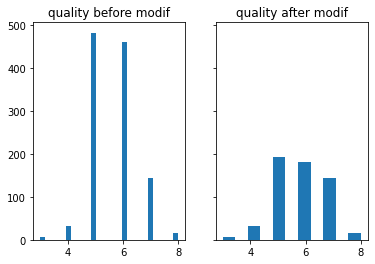

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
X_train=np.transpose(np.asmatrix(X_train))
nb_feature=len(X_features)
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2.shape)
print(X_norm2.shape)

In [16]:
X_train=X_norm2
y_train=y_train2
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
print(int(len(y_train)*0.8)) ## Let's use 80% to train and 20% to eval

from sklearn.preprocessing import LabelEncoder
print(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print(y_train)

459
[5 7 7 5 7 5 5 5 6 5 5 6 7 5 4 6 4 5 5 5 5 4 5 4 6 5 5 4 5 6 6 5 5 5 5 6 5
 6 5 5 7 5 6 5 4 5 5 5 4 5 5 4 6 4 5 5 5 5 6 5 6 5 6 4 7 7 7 6 5 6 5 5 6 6
 7 7 7 6 7 4 5 5 4 8 6 6 6 6 8 7 7 7 5 7 7 5 5 5 6 5 5 6 6 6 7 6 5 7 6 5 7
 7 6 7 6 6 6 5 6 5 7 7 6 5 6 7 7 7 7 8 5 7 5 5 6 7 4 5 7 5 6 7 5 7 7 6 5 7
 6 5 6 6 8 7 7 5 6 6 7 5 8 5 3 5 6 6 5 6 8 5 6 7 7 8 6 5 8 6 6 7 7 7 7 7 7
 6 7 7 6 3 6 7 6 6 6 6 5 6 5 5 6 4 5 5 7 5 8 5 6 5 5 5 5 6 6 5 4 5 5 5 4 7
 5 5 7 6 6 5 6 5 5 5 5 5 5 5 5 6 6 6 4 4 5 5 5 5 5 5 5 6 5 5 5 6 5 6 6 5 5
 5 6 6 5 5 6 5 5 5 6 5 5 7 7 6 7 5 5 6 4 5 7 5 7 4 4 7 7 7 5 6 6 7 7 5 5 4
 7 6 6 6 5 5 5 6 6 7 6 7 7 7 7 6 6 6 6 5 5 7 6 4 5 7 5 5 6 7 7 7 7 7 7 7 7
 7 7 7 6 5 5 6 6 7 5 7 5 5 5 6 6 7 7 7 7 7 7 6 6 7 6 5 6 6 7 5 7 5 7 7 7 6
 6 6 6 5 7 6 7 7 7 6 8 6 7 7 5 7 6 7 7 6 7 6 7 7 8 7 6 7 5 6 6 7 6 6 6 6 6
 6 5 8 7 6 7 7 7 6 6 7 6 7 7 7 5 7 6 4 5 4 5 7 6 6 7 8 7 7 5 7 7 6 6 6 6 5
 5 7 5 6 6 6 4 4 6 5 6 4 6 6 6 6 5 4 7 6 5 5 6 6 3 6 6 6 5 5 5 6 6 5 6 6 6
 6 6 6 6 5 5 6 6 5 6 

In [17]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [20]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-mlogloss:1.71893


/home/henri/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.66690
[2]	validation_0-mlogloss:1.62169
[3]	validation_0-mlogloss:1.58585
[4]	validation_0-mlogloss:1.55297
[5]	validation_0-mlogloss:1.52303
[6]	validation_0-mlogloss:1.50433
[7]	validation_0-mlogloss:1.48916
[8]	validation_0-mlogloss:1.47651
[9]	validation_0-mlogloss:1.46262
[10]	validation_0-mlogloss:1.45209
[11]	validation_0-mlogloss:1.44462
[12]	validation_0-mlogloss:1.43704
[13]	validation_0-mlogloss:1.43036
[14]	validation_0-mlogloss:1.42855
[15]	validation_0-mlogloss:1.42244
[16]	validation_0-mlogloss:1.41865
[17]	validation_0-mlogloss:1.41658
[18]	validation_0-mlogloss:1.41635
[19]	validation_0-mlogloss:1.41613
[20]	validation_0-mlogloss:1.41336
[21]	validation_0-mlogloss:1.41384
[22]	validation_0-mlogloss:1.41554
[23]	validation_0-mlogloss:1.41647
[24]	validation_0-mlogloss:1.42177
[25]	validation_0-mlogloss:1.42716
[26]	validation_0-mlogloss:1.43555
[27]	validation_0-mlogloss:1.44156
[28]	validation_0-mlogloss:1.44729
[29]	validation_0-mlogloss:1.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [21]:
xgb_model.best_iteration

20

In [22]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}")

print(xgb_model.classes_)
#print(xgb_model.classes_)

Metrics train:
	Accuracy score: 0.8537
Metrics test:
	Accuracy score: 0.8537
[0 1 2 3 4 5]
